In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import emcee
import corner
from IPython.display import display, Math

In [3]:
df = pd.read_csv('../all_times.csv')
t = df['T_mid'].to_numpy()
epoch = df['Orbit number'].to_numpy()
uncertainty = df['Uncertainty (days)'].to_numpy()

In [4]:
start_nickel = np.where(epoch==634)[0][0]

dP_dN_true = 1e-10
period_true = 1.4079405
t0_true = 2459204.57267399 # t0 for transit with epoch=302-302=0
f_true = 0.01

In [5]:
epoch -= 302 # try to eliminate correlation between P and dP/dN

In [6]:
def log_likelihood(theta, x, y, yerr):
    dP_dN, period, t0, log_f = theta
    model = (0.5 * dP_dN * 1e-9 * x ** 2) + (period * x) + t0
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

nll = lambda *args: -log_likelihood(*args)
initial = np.array([dP_dN_true, period_true, t0_true, np.log(f_true)])
soln = minimize(nll, initial, args=(epoch, t, uncertainty))
dP_dN_ml, period_ml, t0_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("dP_dN= {0:.3f}".format(dP_dN_ml))
print("P = {0:.3f}".format(period_ml))
print("t0 = {0:.3f}".format(t0_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

Maximum likelihood estimates:
dP_dN= 1.287
P = 1.408
t0 = 2459204.572
f = 0.000


In [7]:
def log_prior(theta):
    dP_dN, period, t0, log_f = theta
    if -1000 < dP_dN < 1000 and -5.0 < period < 5.0 and 2459204-1000 < t0 < 2459204+1000 and -30.0 < log_f < -20.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [7]:
pos = soln.x + 1e-4 * np.random.randn(128, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(epoch, t, uncertainty)
)
sampler.run_mcmc(pos, 50000, progress=True);

100%|██████████| 50000/50000 [01:13<00:00, 683.69it/s]


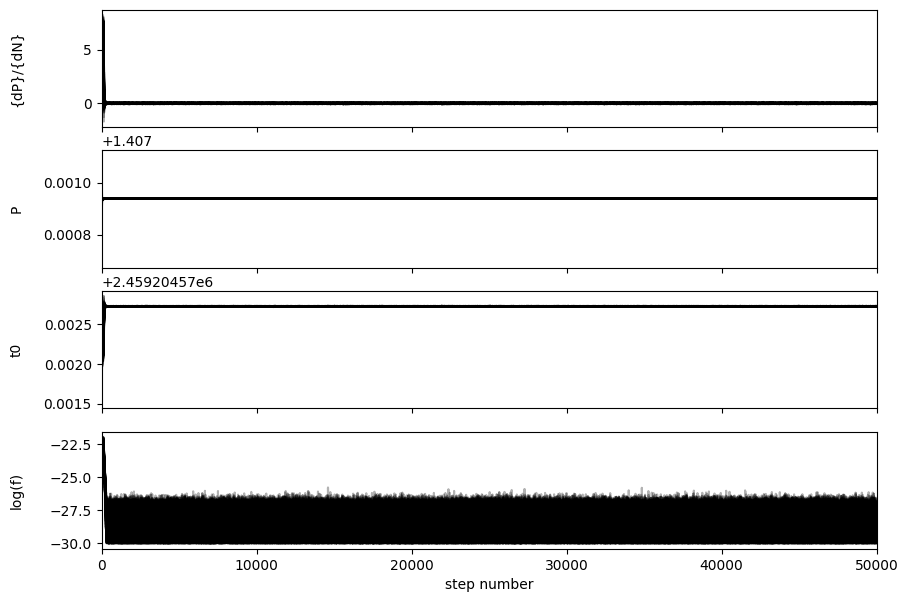

In [8]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["{dP}/{dN}",'P', "t0", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

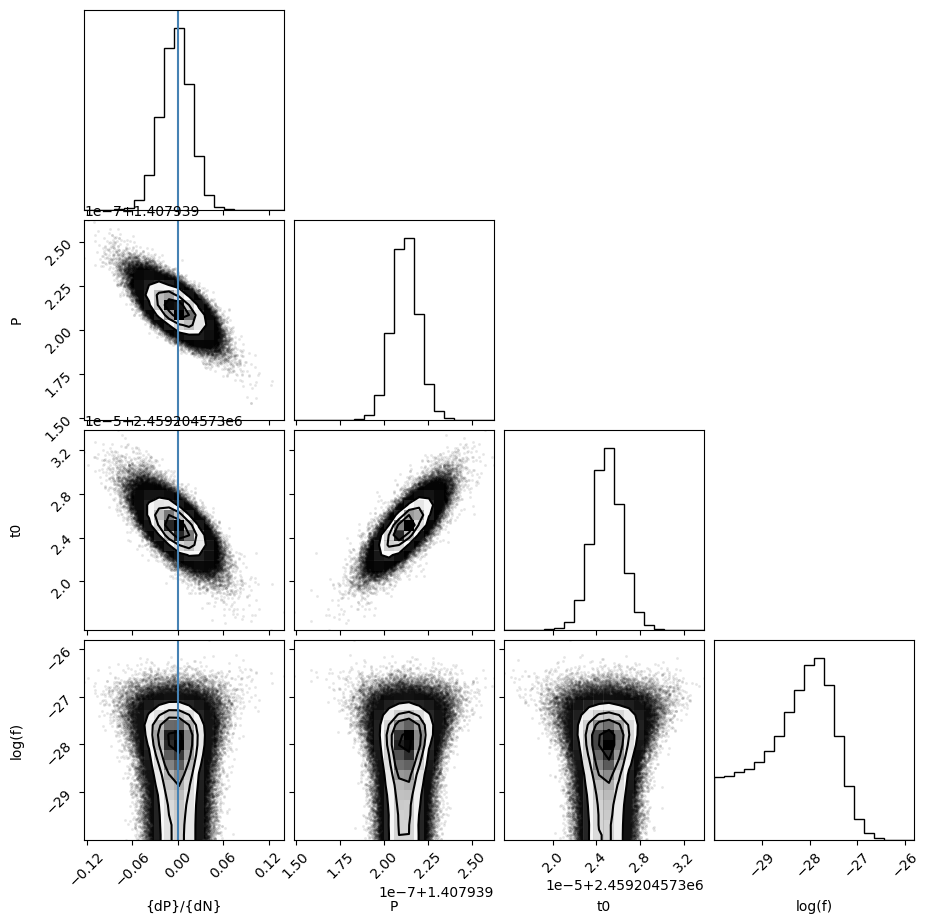

In [9]:
flat_samples = sampler.get_chain(discard=15000, thin=15, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[dP_dN_true, period_true, t0_true, np.log(f_true)]
);

In [10]:
flat_samples[:, 0] *= 1e-9

In [11]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.10f}_{{-{1:.10f}}}^{{{2:.10f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/var/folders/sr/g5sjm4bd55nbc1x4wnqb1dqw0000gn/T/ipykernel_28446/2703471813.py:4: SyntaxWarning: invalid escape sequence '\m'
  txt = "\mathrm{{{3}}} = {0:.10f}_{{-{1:.10f}}}^{{{2:.10f}}}"


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [12]:
best_dP_dN = np.median(flat_samples[:, 0])
best_P = np.median(flat_samples[:, 1])
best_t0 = np.median(flat_samples[:, 2])

trend = (0.5 * best_dP_dN * epoch ** 2) + (best_P * epoch) + best_t0

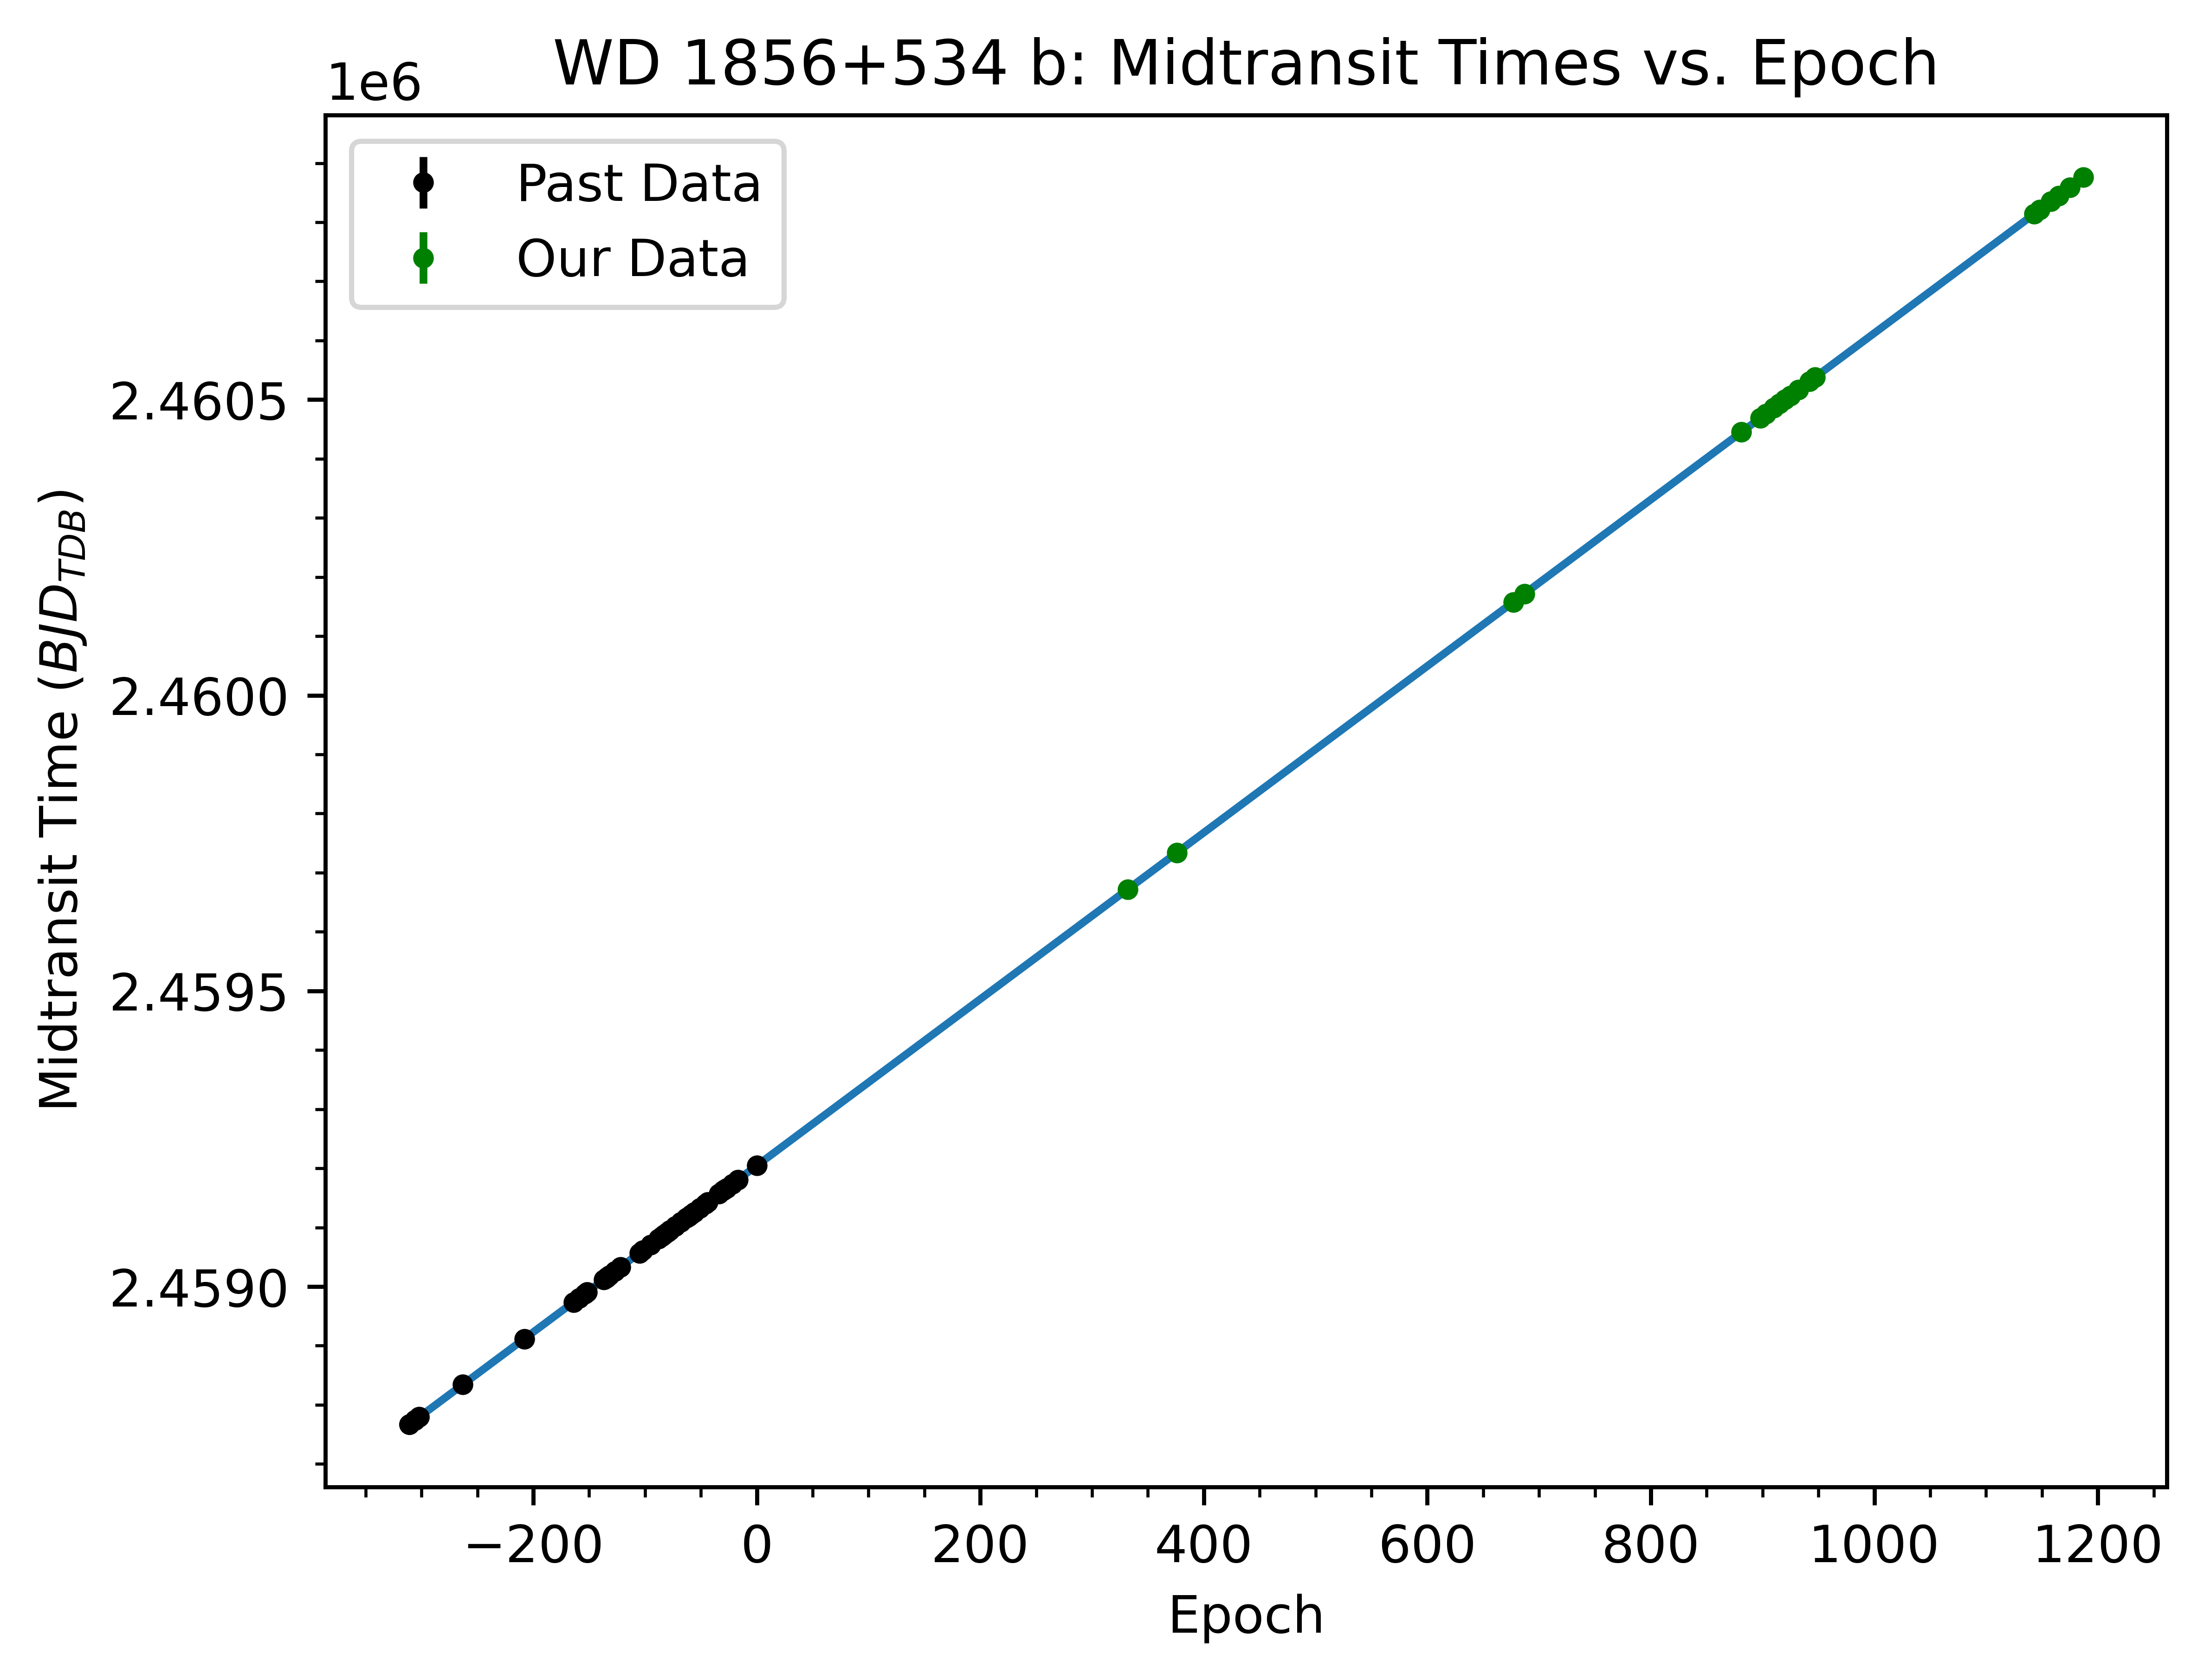

In [9]:
fig, ax = plt.subplots(dpi = 800)
plt.errorbar(epoch[:start_nickel],t[:start_nickel],yerr=uncertainty[:start_nickel],fmt='k.',label='Past Data')
plt.errorbar(epoch[start_nickel:],t[start_nickel:],yerr=uncertainty[start_nickel:],fmt='g.',label='Our Data')
plt.plot(epoch,trend)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Midtransit Time $(BJD_{TDB})$')
plt.title('WD 1856+534 b: Midtransit Times vs. Epoch')
ax.minorticks_on()

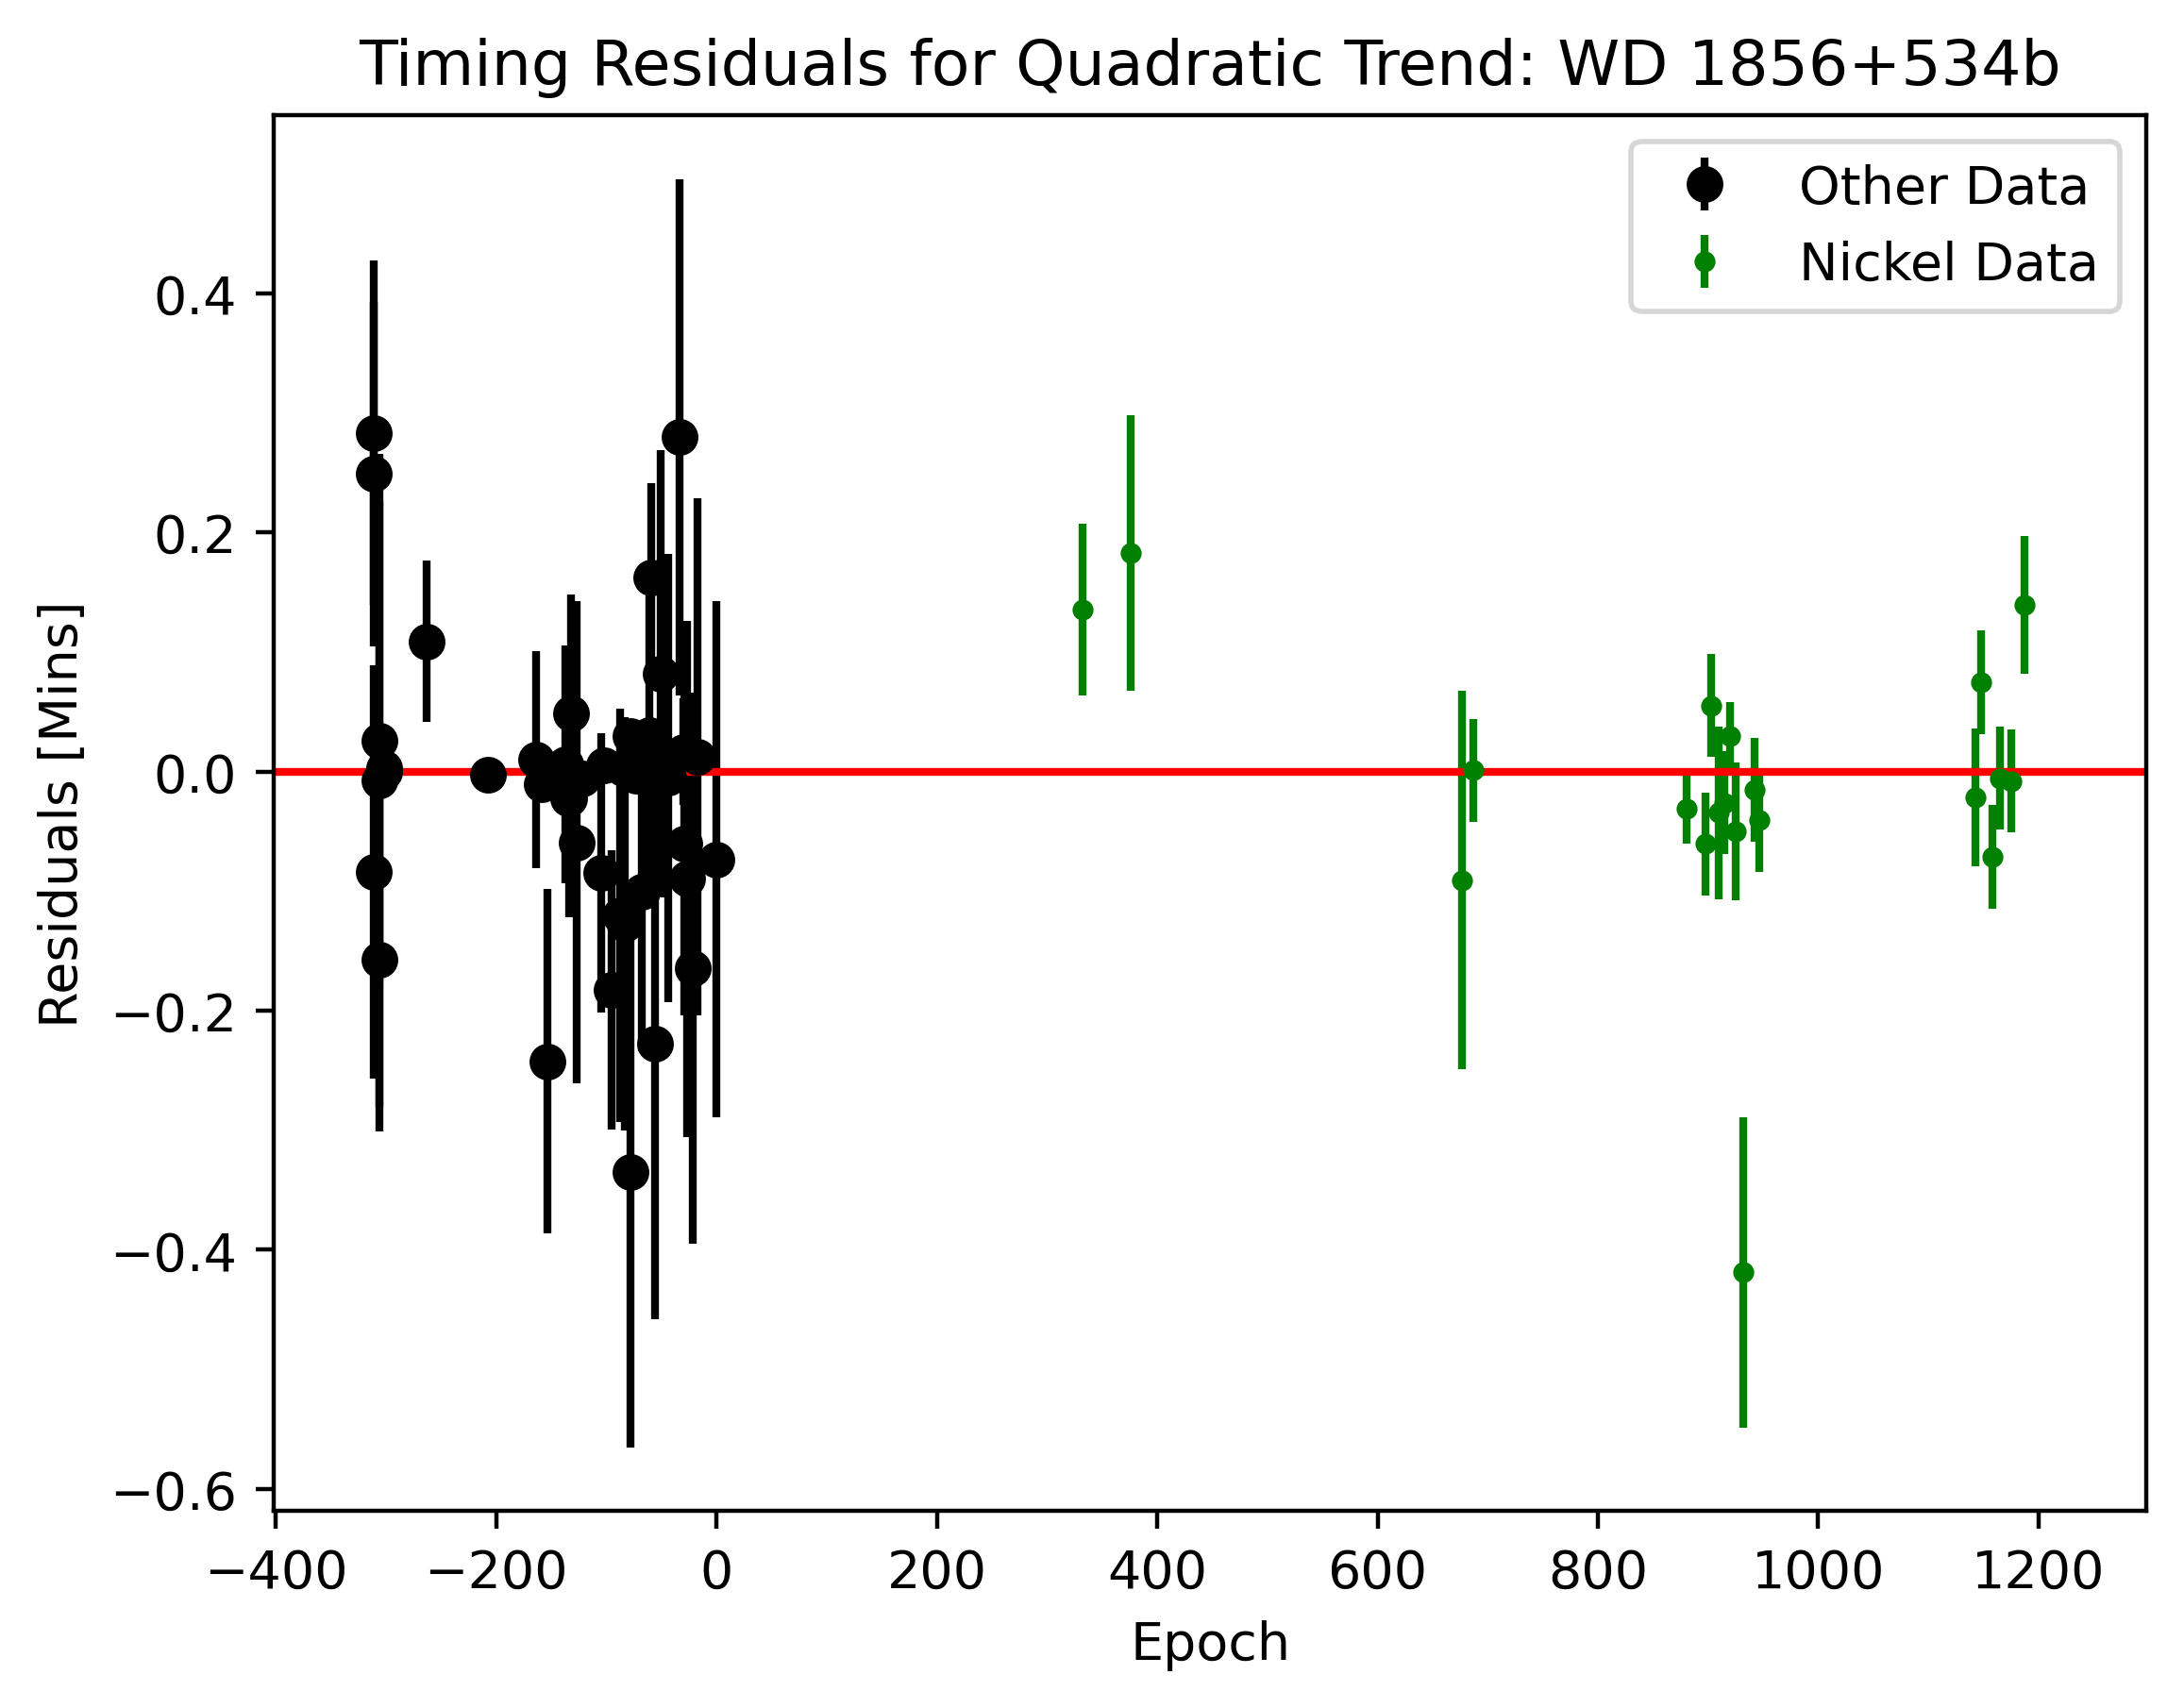

In [10]:
res = (t - trend) * 1440 # 1440 converts days to mins

plt.figure(dpi=400)
plt.errorbar(epoch[0:start_nickel],res[0:start_nickel],yerr=uncertainty[0:start_nickel]*1440,fmt='ok',capsize=0,label='Other Data')
plt.errorbar(epoch[start_nickel:],res[start_nickel:],yerr=uncertainty[start_nickel:]*1440,fmt='g.',capsize=0,label='Nickel Data')
plt.legend()
plt.xlim(-100-302,1600-302)
plt.hlines(y=0,xmin=-2500,xmax=2500,color='red')
plt.ylabel('Residuals [Mins]')
plt.xlabel('Epoch')
plt.title('Timing Residuals for Quadratic Trend: WD 1856+534b')
ax.minorticks_on()
plt.legend(loc='best')

In [15]:
def chi_squared_reduced(data, model, sigma, dof=None):
    """
    Calculate the reduced chi-squared value for a fit.

    If no dof is given, returns the chi-squared (non-reduced) value.

    Parameters
    ----------
    data : array_like
        The observed data.
    model : array_like
        The model data.
    sigma : array_like
        The uncertainty in the data.
    dof : int
        Degrees of freedom (len(data) - # of free parameters).
    """

    sq_residual = (data - model)**2
    chi_sq = np.sum(sq_residual / sigma**2)
    if dof is None:
        return chi_sq
    else:
        nu = len(data) - dof
        return chi_sq / nu

# Define our data, model, uncertainty, and degrees of freedom
I_data = t  # observed data
I_modeled = trend # model fitted result
I_sigma = uncertainty # uncertainty in the data

# Calculate the Chi-Squared value (no dof)
chisq = chi_squared_reduced(I_data, I_modeled, I_sigma)
print(f"chi-squared statistic = {chisq:1.2f}")

# Calculate the Reduced Chi-Squared value (with dof)
dof = 3 # We have three free parameters
rechisq = chi_squared_reduced(I_data, I_modeled, I_sigma, dof)
print(f"reduced chi-squared = {rechisq:1.2f}")

chi-squared statistic = 94.22
reduced chi-squared = 1.45


In [16]:
BIC = chisq + 2*np.log(len(I_data))
print(f"BIC = {BIC:1.2f}")

BIC = 102.66
